# Parallel Processing Basics Part 1:  dask
This is second-level notebook on MsPASS fundamentals.  It can only be run 
after completion of the "getting_started.ipynb" while running the container rooted at the same working directory where you ran that first tutorial.  You will need that to get access to the MongoDB database created in that tutorial.

The learning objective of this tutorial is these elements of developing a parallel workflow in MsPASS:
1.  Guidance on how to develop the python code that defines your workflow to run in parallel.   That development normally should be done on a small subset of the data as a "serial job" before transforming the task to a parallel job.
2.  How to translate your serial prototype into a parallel job.

MsPASS supports two different "schedulers" for handling parallel processing:  (1) dask, and (2) spark (technically pyspark).  This tutorial shows how to build a parallel workflow using dask.  Part 2 is a followup to this notebook that shows how to build the identical, parallel workflow using pyspark.   Part 2 is a separate notebook because the container needs to be started with a different run line than for dask.

This notebook is best run with access to the dask diagnostic port (default is 8787).  If you are running a cluster you are likely already set up to access 8787.   If you are running on desktop/laptop with docker you should make sure you start the container with some variant of this run line:
```
docker run -p 8888:8888 -p 8787:8787 --mount src=`pwd`,target=/home,type=bind mspass/mspass
```

First, the usual connection to the database.

In [1]:
from mspasspy.db.database import Database
import mspasspy.client as msc
dbclient=msc.Client()
db = dbclient.get_database('getting_started')

Then doing a series of imports needed to support the workflow.  Note common practice is that during development of a workflow in a notebook it is a good idea to keep most imports at the top like this, add to the code as needed, and after each change push the run button.

In [2]:
from mspasspy.io.distributed import read_distributed_data,write_distributed_data
from mspasspy.algorithms.window import WindowData,scale
from mspasspy.algorithms.basic import ator
from mspasspy.ccore.algorithms.basic import TimeWindow
from mspasspy.ccore.utility import ErrorSeverity
from mspasspy.db.normalize import ObjectIdMatcher,normalize
from mspasspy.algorithms.signals import filter
from obspy import UTCDateTime
import time

## Serial Prototype
A key concept to understand about the normal model for parallel processing with MsPASS is that most workflows of interest can be prototyped as a top-level loop over data.   i.e. in pseudocode the processing boils down to `foreach datum do something` where the `something` is a chain of processing algorithms.   That type of data handling is commonly called a "pipeline" and is universally recognized as "embarrassingly parallel".   That means simply that parallel processing can nearly always perform well and scale close to optimal values based on __[Amdahl's Law](https://en.wikipedia.org/wiki/Amdahl%27s_law)__.

Because most processing workflows can be reduced to a pipeline, we have found that it is always wise to prototype your workflow code with a "serial" version that defines a loop over data.   In hopes of making that less abstract here is the serial version of the processing sequence we will run repeatedly in this tutorial.   More on what this box contains is in a text box after the code.  

In [3]:
def shift_by_Ptime(d):
    if d.live:
        if d.is_defined('Ptime'):
            tshift = d['Ptime']
            d = ator(d,tshift)
        else:
            d.kill()
            d.elog.log_error("shift_by_Ptime",
                             "Required key Ptime is was not defined",
                             ErrorSeverity.Invalid)
    return d

In [4]:
stime = -60.0
etime = 300.0
station_normalizer = ObjectIdMatcher(db,
                                    collection='channel',
                                    attributes_to_load=[
                                            '_id',
                                            'lat',
                                            'lon',
                                            'elev',
                                            'hang',
                                            'vang',
                                           ]
                                          ) 
source_normalizer = ObjectIdMatcher(db,
                                    collection='source',
                                    attributes_to_load=[
                                            '_id',
                                            'lat',
                                            'lon',
                                            'depth',
                                            'time',
                                            'magnitude',
                                           ]
                                          )
t0 = time.time()
output_data_tag = 'serial_prototype'
query={'data_tag' : 'preprocessed'}   # data tag of save in getting_started
nwf = db.wf_TimeSeries.count_documents(query)
print("Processing ",nwf," waveforms")
cursor = db.wf_TimeSeries.find({'data_tag' : 'preprocessed'})
for doc in cursor:
    d = db.read_data(doc,
                     collection='wf_TimeSeries',
                     normalize=[source_normalizer])
    # this could have been done in read_data but useful illustration for tutorial
    d = normalize(d,station_normalizer)
    d = shift_by_Ptime(d)
    # filter before windowing - gets rid of filter startup transients
    d = filter(d,type='bandpass',freqmin=0.01,freqmax=1.0)
    d = WindowData(d,stime,etime)
    save_output = db.save_data(d,data_tag=output_data_tag)
t=time.time()
print("Processing time=",t-t0)
print("Time per datum=",(t-t0)/nwf)
print("Last value output by db.save_data=",save_output)

Processing  7803  waveforms
Processing time= 134.49936723709106
Time per datum= 0.017236879051274006
Last value output by db.save_data= {'is_live': True, '_id': ObjectId('65dc7f7a2252b80c3c8fabef')}


Things to note about this code that defines this "workflow" are:
1.  The biggest point here is the for loop.  It defines an iteration over data using a MongoDB `Cursor`.   In MsPASS cursor-driven loops are a common construct.   A `Cursor` acts like a python list so we can us it in python programiong constructs like `for doc in cursor:`.   In reality, however, it is something very different as a Cursor interacts with MongoDB to essentially assure as the loop progresses MongoDB will feed it "documents", which it stores in the `doc` symbol, to be handled sequentially.   The loop terminates when the result of the query is exhausted.
2.  The loop is driven by "documents" (defined with the symbol here `doc`) retrieved from the "wf_TimeSeries" collection.   (Note "wf_TimeSeries" is not actually required in the above context as it is the default for the collection argument.  It is included to emphasize the point that the collection definition is critical for the reading to succeed.)
3.  The first process is a "call to the read_data method of Database".  For this style of data loop `read_data` is driven by an input "document".  A lot is hidden behind that one line to construct a complete `TimeSeries` object.  As noted in our getting_started tutorial our aim was to abstract the read and write operators as much as possible to hide the grungy details of what it takes to make that work.   As you learn MsPASS you may want or need to read about such details in the User's Manual.
4.  We used the `normalize` argument in `read_data` to load source metadata with each datum.   We load the station metadata in a separate step using the `normalize` function run immediately below the call to `read_data`.  (As the comment states we could have done both during read but we use the `normalize` function here for the educational value it provides.)  Both normalizations use a different scheme than that in "getting_started".  Both use an id matching algorithm.  Above the loop we create the two "matchers" assigned the symbols `station_matcher` and `source_matcher`.   The approach here works ONLY because getting started set two key attributes stored with each `doc` processed in this loop:  (1) `channel_id` is the cross-referencing id for "channel" and (2) `source_id` is the cross-referencing id for source.  "Normalization" is an important side topic addressed at length in the User's Manual and other tutorials. It is secondary here, and is not, in fact, actually even needed in this workflow.  We included it just for its instructional value noting that for production work normalization with id matching using values defined by preprocessing is usually a good model for seismic data processing.
6.  We apply three processing functions:  (1) `shift_by_Ptime` is defined in the box immediatly above.  It changes from UTC to "relative" time with 0 defined by the value of the "Ptime" attribute retrieved from each datum by the function.  (2) We apply a fairly common bandpass filter for processing teleseismic body waves.  (3) `WindowData` cuts the larger waveform segment down to a smaller window from 60 s before (minus sign) Ptime to 300 s after the time defined by the "Ptime" key.  Note the values of `stime` and `etime` are "relative time", which in this case uses the value of "Ptime" as 0.  We can use relative time at this point in the processing chain because the `shift_by_Ptime` function applies the `ator` function to define 0 as the P time set by the processing loop in the getting_started tutorial.  
7.  The last step the processing loop is to save the data to the database.   An important details is that the `data_tag` value is almost always desirable on a save.  Normal practice is to stuff all results into a single "wf collection" like "wf_TimeSeries".   The only way you can examine a specific version of results is to use the "data_tag" field to look at the results.

Finally, let's retrieve a subset (20 signals in whatever order they were posted to the db) of what we just saved and plot it to see that the processing did what we expected it to.

magnitude of event= 6.7


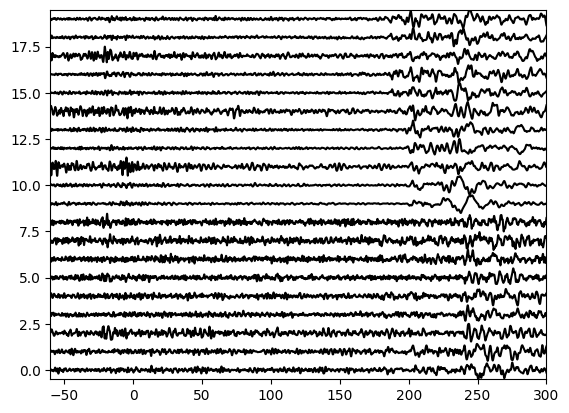

In [5]:
from mspasspy.graphics import SeismicPlotter
output_data_tag = 'serial_prototype'   # duplicated for clarity
plotter = SeismicPlotter()
plotter.change_style('wt')
cursor=db.wf_TimeSeries.find({'data_tag' : output_data_tag}).limit(20)
ensemble=db.read_data(cursor,
                      collection='wf_TimeSeries',
                      normalize=[source_normalizer])
ensemble = scale(ensemble,level=0.5)
plotter.plot(ensemble)
# This works only because we used normalize on read and loaded magnitude 
# as an attribute when we created source_normalizer
print("magnitude of event=",ensemble.member[0]['source_magnitude'])

In [6]:
# delete me before release - sanity check  needs a mod to select specific event or comment that this is an aftershock
print(ensemble.member[0].t0)
print(ensemble.member[0].dt)
srcid = ensemble.member[0]['source_id']
doc=db.source.find_one({'_id' : srcid})
print(doc['magnitude'])

-60.0
0.025
6.7


The printing of the magnitude is helpful as it illstrates why the P wave is not so clear on the graphic.   This is a smaller event for which P is not particularly clear.  The stronger phase around 200 s is PP.  

### Parallel Workflow with dask distributed
As noted at the top there are two "schedulers" that can be used in MsPASS.  The default is __[dask](https://www.dask.org/)__.  There are currently two different "schedulers" available in dask.  We recommend the newer one called __[dask distributed]()__.   It is enabled by default when running the MsPASS container.  


A feature we will explore in this tutorial is dask's __[diagnostic monitor](https://distributed.dask.org/en/stable/diagnosing-performance.html)__.  It is very useful for monitoring performance of a long-running job and to verify your cluster setup is configured correctly.  If you launched the MsPASS container properly, the status page diagnostics page should now be available to you and can be accessed via port 8787.   It is because of that requirement that we asked you to start the container with the `-p 8787:8787` incantation in docker. (Note a different incantation may be necessary if you are running this on a cluster instead of a desktop/laptop with docker.)  Without that port mapping you would not be able to connect to the diagnostics page.   We note that in our experience using the hyperlink above will not always work either.   You instead will probably need to use the link via the default localhost of `127.0.0.1:8787/status` or using some specific hostname on a cluster.  You might be able to click on [this link](http://127.0.0.1:8787/status).   If that doesn't work resort to a cut and paste of the above url. 

Now that you can view the dask dashboard, let's run a variation of the above workflow that will do the same processing in parallel.   We will discuss the programming details below, but for now we suggest you run this code and play with the diagnostics monitor while it runs.  A last point before you run the next box is that IF you choose to run the box below more than once, CHANGE THE VALUE OF `output_data_tag`.  If you don't you won't be able to untangle the multiple runs. 

In [7]:
stime = -60.0
etime = 300.0
station_normalizer = ObjectIdMatcher(db,
                                    collection='channel',
                                    attributes_to_load=[
                                            '_id',
                                            'lat',
                                            'lon',
                                            'elev',
                                            'hang',
                                            'vang',
                                           ]
                                          ) 
source_normalizer = ObjectIdMatcher(db,
                                    collection='source',
                                    attributes_to_load=[
                                            '_id',
                                            'lat',
                                            'lon',
                                            'depth',
                                            'time',
                                            'magnitude',
                                           ]
                                          )
output_data_tag='dask_parallel_example'
t0 = time.time()
dataset = read_distributed_data(db,
                collection='wf_TimeSeries',
                normalize=[source_normalizer],
                data_tag='preprocessed',
            )
dataset = dataset.map(normalize,station_normalizer)
dataset = dataset.map(shift_by_Ptime)
dataset = dataset.map(filter,type='bandpass',freqmin=0.01,freqmax=1.0)
dataset = dataset.map(WindowData,stime,etime)
write_result = write_distributed_data(dataset,
                        db,
                        data_tag=output_data_tag,
                    )
t=time.time()
print("Total processing time=",t-t0)

Total processing time= 492.35414600372314


Compare the above with the earlier serial job.  The for loop command and read_data line are replaced by the following line:
```
bg = read_distributed_data(db,cursor,normalize=['source'])
```
The `read_distributed_data` function creates a container called a dask "bag".  A convenient way to view a bag is list of things that doesn't need to fit in memory.   The "things", in our case, are mspass TimeSeries objects.   The `read_distributed_data` line is followed by a series of lines that in python jargon apply the "map method" of the "bag" object/container. The concept of a "map" operator is one of the two keywords in the modern concept of the "map-reduce" model of big data science.  You can find many web pages and turorials discussing map-reduce in general and map-reduce for dask in particular.   For now, we emphasize that arg0 of the map method is a function name.  Each call to map applies a named function to data that it assumes emits another datum that is always the same type for each instance.  i.e. there is one output for each datum received via arg0 of the function call.  All the processing functions in the loop above use that model.  For example, the `resample` function takes an input TimeSeries of any sample rate and returns a resampled representation of that datum at 20 sps.  

With that background, note the workflow runs a sequence of algorithms through the map method driven by the same function names as above in the same order. For example, consider this line in the serial job that runs the normalize function we used earlier:
```
d = normalize(d,station_matcher)
```
The comparable operator above is this:
```
bg = bg.map(normalize,station_matcher)
```
The key point we want to make here is that it is straightforward to convert any loop like the serial job to a parallel version using dask.  Each of the processing function calls are translated to a string of arguments passed to the dask bag map method.  If you compare the box above to the serial version you could see the pattern of how to do that with dask; arg0 of the map call is the function name and other arguments follow AFTER stripping arg0 (the datum to be processed) from the list.   

A feature of dask potentially confusing to newcomers is that all the calls the the bag "map method" are "lazy".   What that means is nothing is actually computed until we call the bag's "compute method".  An implementation detail of this example is that the "compute method" is hidden behind the final function call to the MsPASS function `write_distributed_data`.   `write_distributed_data` is always a terminator for a processing sequence.  It saves the parallel job stream output using a parallel io algorithm utilized under the hood in that function.   The last line of the above box could be replaced by the following and the result would be the same.  It would normally, however, run slower because the IO steps would be subject to more delays from "blocking"  (see User's Manual for a discussion of parallel IO in MsPASS).
```
dataset = dataset.map(db.save_data,data_tag=output_data_tag)
dataset.compute()
```

### Tuning
Results will vary with hardware, but in many cases the parallel job above will actually take longer to run than the serial job.   Why, is largely an issue of a mismatch in default configurations for docker and dask with what we just ran.  The biggest problem, at present, seems to be that the dask by default is using what is called a "thread pool" shared by the processing tasks that fight each other.  The conflict comes from an obscure python concept called the "Global Interpreter Lock" (GIL) that in the default configuration allows only one thread to execute simultaneously.   As a result, the above is actually often slower than the serial job because the GIL allows only one thread to execute simultanelously making it effectively a serial job.   It can take longer because of the additional overhead of the scheduler and moving data between tasks.   That particular problem is less likely to surface when running on a cluster for a number of reasons, but the real lesson is this:  optimizing parallel performance often requires digging deeper and doing some tuning to scheduler (dask or spark) configurations.   Whether or not the effort to do that tuning is justified is dependent upon the scale of the problem you are facing. e.g. if you are only going to do something once or twice and you find the computation is feasible with a serial workflow, you probably don't need to mess with the complexities of tuning a parallel workflow.  If, however, you estimate your job will require weeks to months of processing with a serial job, or you need to run a workflow on dozens of data sets each of which requires days, the effort to transfer the workflow to a large cluster is justified.  For guidance on tuning dask see the sections of the MsPASS User's manual on parallel processing and consult numerous web sources on the topic.     